In [1]:
%matplotlib inline
from inc.notebook009 import *

In [2]:
csv = Bundler.get_bundle('only_memory').get_file('only_memory.csv')
data = pd.read_csv(csv)

# Wikipedia - Stage Regression

## Stage 0

Number of tasks is the number of HDFS blocks.

In [3]:
cols = ['set', 'input', 'workers', 'duration_ms', 's00_dur', 's01_dur', 's02_dur']
group_cols = [c for c in cols if not c.endswith('_dur') and c != 'duration_ms']
wiki = data.query('application == "wikipedia" and input > 128 * 1024**2')
wiki = wiki[cols].groupby(group_cols).median().reset_index()
wiki.input /= 1024**2
wiki[['duration_ms', 's00_dur', 's01_dur', 's02_dur']] /= 1000
wiki['others'] = wiki.duration_ms - wiki.s00_dur - wiki.s01_dur - wiki.s02_dur

profiling = wiki.query('set == "profiling"')
target = wiki.query('set == "target"').sort_values('workers')

# Prediction accumulator for total application time.
## Start with the same input and workers for the profiling set.
preds = profiling.copy()
### (erase durations - they will be predicted)
preds[['duration_ms', 's00_dur', 's01_dur', 's02_dur', 'others']] = np.nan
## Then, add more workers for the target set.
### Make sure there's only one input size for the target set.
target_inputs = target.input.unique()
assert len(target_inputs) == 1
target_input = target_inputs[0]
for workers in range(4, 65):
    preds = preds.append([{'set': 'target', 'input': target_input, 'workers': workers}])

In [4]:
wiki

,set,input,workers,duration_ms,s00_dur,s01_dur,s02_dur,others
0,profiling,255.990643,1,20.0150,9.1215,3.1085,0.0710,7.7140
1,profiling,511.948339,1,23.7595,12.5945,3.4160,0.0695,7.6795
2,profiling,1023.999975,1,30.0050,18.2570,4.0020,0.0665,7.6795
3,profiling,1023.999975,2,23.4300,12.9380,3.2970,0.0615,7.1335
4,profiling,1023.999975,4,20.2985,10.3240,2.5625,0.0655,7.3465
5,target,46294.094807,4,183.8815,158.6620,17.1895,0.1065,7.9235
6,target,46294.094807,8,103.3815,83.6635,11.4915,0.1010,8.1255
7,target,46294.094807,16,64.6870,48.5005,7.4655,0.1205,8.6005
8,target,46294.094807,32,44.0230,29.4780,5.5035,0.1225,8.9190
9,target,46294.094807,64,36.7975,22.1825,4.4870,0.2035,9.9245


In [5]:
def get_x(df):
    ipw = df.input / df.workers
    return pd.DataFrame({'input_per_worker': ipw}, index=df.index)
    
model = LinearRegression()
x = get_x(profiling)
y = profiling.s00_dur
model.fit(x, y)

x = get_x(target)
y = target.s00_dur
rmse = mean_squared_error(y, model.predict(x))**0.5
print('RMSE =', rmse, 'sec')
print(model.intercept_, model.coef_)

RMSE = 13.1803964741 sec
6.95765841757 [ 0.01111226]


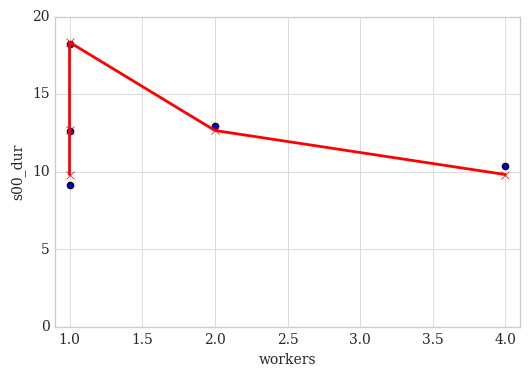

In [6]:
ax = profiling.plot.scatter('workers', 's00_dur', ylim=(0, None), xlim=(0.9, 4.1))

x = get_x(profiling)
y_pred = model.predict(x)
ax.plot(profiling.workers, y_pred, 'r-x');

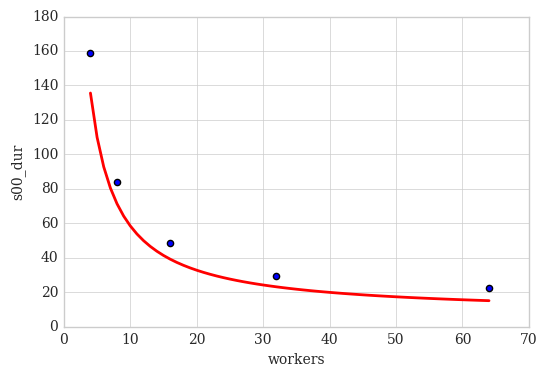

In [7]:
ax = target.plot.scatter('workers', 's00_dur')

target_inputs = target.input.unique()
assert len(target_inputs) == 1
target_input = target_inputs[0]

workers = np.array(range(4, 65))
x = pd.DataFrame({'input_per_worker': target_input / workers})
y_pred = model.predict(x)
ax.plot(workers, y_pred, color='r')
preds.s00_dur = model.predict(get_x(preds))

## Stage 1

Always 200 tasks.

In [8]:
def get_x(df):
    ipw = df.input / df.workers
    return pd.DataFrame({'input_per_worker': ipw}, index=df.index)
    
model = LinearRegression()
x = get_x(profiling)
y = profiling.s01_dur
model.fit(x, y)

x = get_x(target)
y = target.s01_dur
rmse = mean_squared_error(y, model.predict(x))**0.5
print('RMSE =', rmse, 'sec')
print(model.intercept_, model.coef_)

RMSE = 1.42488215085 sec
2.4995686165 [ 0.00151885]


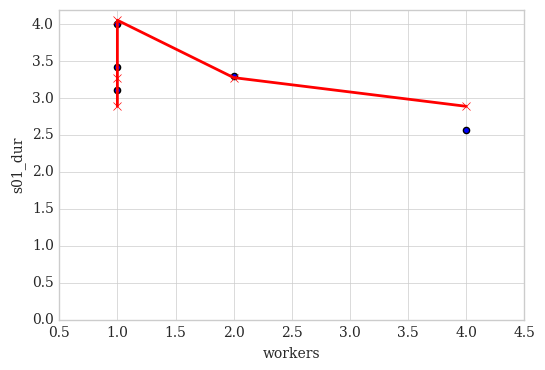

In [9]:
ax = profiling.plot.scatter('workers', 's01_dur', ylim=(0, None))
x = get_x(profiling)
y_pred = model.predict(x)
ax.plot(profiling.workers, y_pred, 'r-x');

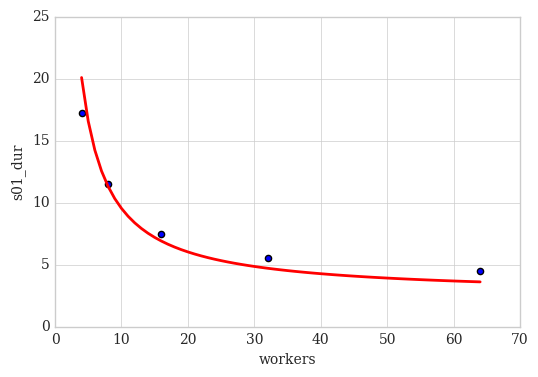

In [10]:
ax = target.plot.scatter('workers', 's01_dur')

target_inputs = target.input.unique()
assert len(target_inputs) == 1
target_input = target_inputs[0]

workers = np.array(range(4, 65))
x = pd.DataFrame({'input_per_worker':target_input / workers})
pred = model.predict(x)
ax.plot(workers, pred, color='r')
preds.s01_dur = model.predict(get_x(preds))

## Stage 2

Always 1 task. Input and workers are the best features for all data, but results are better with a constant when training with the profiling data.

In [11]:
def get_x(df):
    return pd.DataFrame(np.ones(len(df)), index=df.index)
    
model = LinearRegression(fit_intercept=False)
x = get_x(profiling)
y = profiling.s02_dur
model.fit(x, y)

x = get_x(target)
y = target.s02_dur
rmse = mean_squared_error(y, model.predict(x))**0.5
print('RMSE =', rmse, 'sec')
print(model.intercept_, model.coef_)

RMSE = 0.0740524138702 sec
0.0 [ 0.0668]


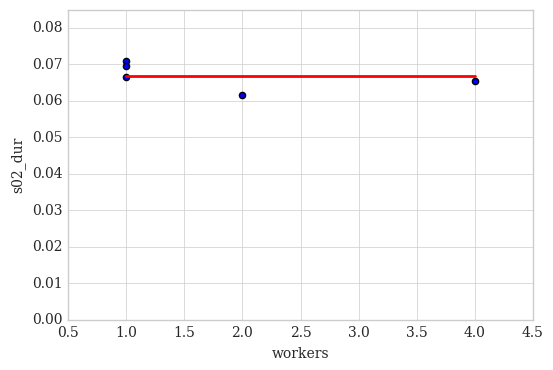

In [12]:
ax = profiling.plot.scatter('workers', 's02_dur', ylim=(0, None))

x = get_x(profiling)
pred = model.predict(x)
ax.plot(profiling.workers, pred, color='r');

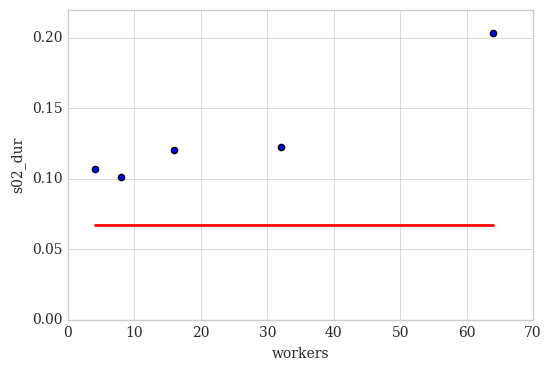

In [13]:
ax = target.plot.scatter('workers', 's02_dur', ylim=(0, None))

workers = np.array(range(4, 65))
# x = pd.DataFrame(np.ones(len(workers)))
pred = [model.coef_[0]] * len(workers)
ax.plot(workers, pred, color='r')
preds.s02_dur = model.predict(get_x(preds))

## Others

In [14]:
def get_x(df):
#     return df[['workers']]
    return pd.DataFrame(np.ones(len(df)), index=df.index)
    
model = LinearRegression(fit_intercept=False)

x = get_x(profiling)
y = profiling.others
model.fit(x, y)

x = get_x(target)
y = target.others
rmse = mean_squared_error(y, model.predict(x))**0.5
print('RMSE =', rmse, 'sec')
print(model.intercept_, model.coef_)

RMSE = 1.38180853956 sec
0.0 [ 7.5106]


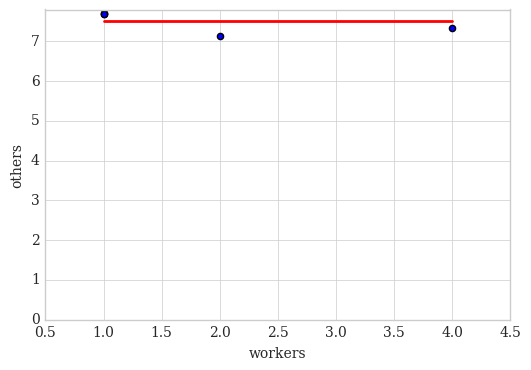

In [15]:
ax = profiling.plot.scatter('workers', 'others', ylim=(0, None))

x = get_x(profiling)
pred = model.predict(x)
ax.plot(profiling.workers, pred, color='r');

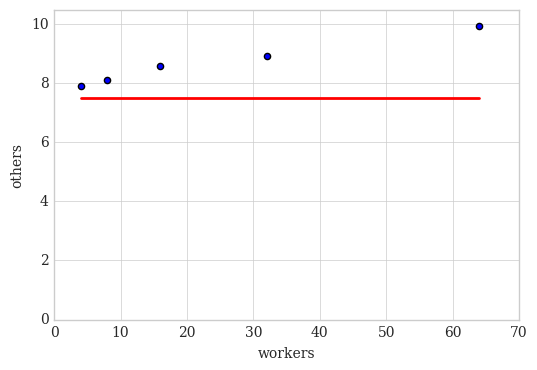

In [16]:
ax = target.plot.scatter('workers', 'others', ylim=(0, None))

workers = np.array(range(4, 65))
x = pd.DataFrame(np.ones(len(workers)))
# x = pd.DataFrame(workers)
pred = model.predict(x)
ax.plot(workers, pred, color='r')
preds.others = model.predict(get_x(preds))

## Total duration

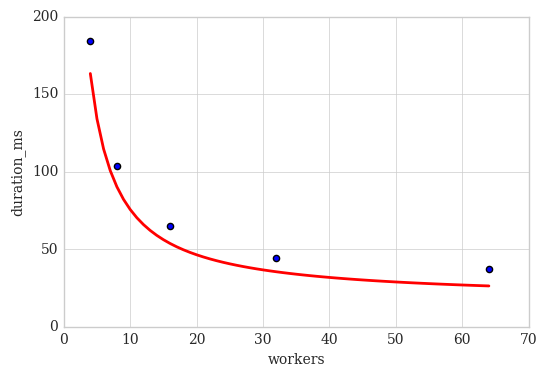

In [17]:
ax = target.plot.scatter('workers', 'duration_ms', ylim=(0, None))
preds.duration_ms = preds[['s00_dur', 's01_dur', 's02_dur', 'others']].sum(axis=1)
tgt_preds = preds.query('set == "target"')
ax.plot(tgt_preds.workers, tgt_preds.duration_ms, color='r');

In [18]:
y_true = wiki
y_pred = preds.query('set == "profiling" or [4, 8, 16, 32, 64] in workers').reset_index()

In [19]:
prof_true = y_true.query('set == "profiling"').duration_ms
prof_pred = y_pred.query('set == "profiling"').duration_ms
mean_squared_error(prof_true, prof_pred)**0.5

0.16624513322525947

In [20]:
target_true = y_true.query('set == "target"').duration_ms
target_pred = y_pred.query('set == "target"').duration_ms
mean_squared_error(target_true, target_pred)**0.5

13.525683936820331